# Configuration

In [1]:
# Data
input_filenames = "/Users/Gonzalo/github/NEXTdata/MC/ECEC/*.h5"

max_energy = "auto"
max_charge = "auto"

# Style
figure_size     = 12, 8
font_size       = 20
line_width      = 4
line_colors     = "k", "m", "b", "g", "r"
default_cmap    = "jet"

# Imports

In [2]:
import os
import glob
import cycler
import operator as op

import numpy             as np
import tables            as tb
import pandas            as pd
import matplotlib.pyplot as plt

from invisible_cities.database.load_db    import DataSiPM
from invisible_cities.core.core_functions import weighted_mean_and_std
from invisible_cities.reco.xy_algorithms  import corona

# Set globals

In [3]:
input_filenames = glob.glob(os.path.expandvars(input_filenames))[:10]
datasipm        = DataSiPM()
sipm_pos        = np.stack((datasipm.X, datasipm.Y), axis=1)

# Style

In [4]:
%matplotlib inline

plt.rcParams["figure.figsize"   ] = figure_size
plt.rcParams[  "font.size"      ] =   font_size
plt.rcParams[ "lines.linewidth" ] =   line_width
plt.rcParams[ "patch.linewidth" ] =   line_width
plt.rcParams[   "axes.linewidth"] =   line_width - 1
#plt.rcParams[ "lines.color"     ] =   line_color
#plt.rcParams[ "patch.edgecolor" ] =   line_color
plt.rcParams[  "axes.prop_cycle"] = cycler.cycler(color=line_colors)
plt.rcParams[  "image.cmap"     ] = default_cmap


# Helpers

In [5]:
def is_corrupt(filename):
    try                   : tb.open_file(filename).close(); return False
    except tb.HDF5ExtError:                                 return True

def get_number_of_events(filename):
    with tb.open_file(filename) as file:
        pmtrd   = file.root. pmtrd
        sipmrd  = file.root.sipmrd
        runinfo = file.root.Run.events
        
        nevt_pmt  =   pmtrd.shape[0]
        nevt_sipm =  sipmrd.shape[0]
        nevt_run  = runinfo.cols.evt_number.shape[0]

    ok = nevt_pmt == nevt_sipm == nevt_run
    return ok, (nevt_pmt if ok else 0)
    
def file_is_ok(filename):
    return not is_corrupt(filename) and get_number_of_events(filename)[0]

def compute_average_xy(wfs):
    sipm_qs  = wfs.sum(axis=1)
    if not np.any(sipm_qs > 0): return (201, 201, 0, 0)
    clusters = corona(sipm_pos, sipm_qs, lm_radius=-1, Qthr=-1, msipm=0) # barycenter!
    b        = next(iter(clusters))
    return b.XY[0], b.XY[1], b.Xrms, b.Yrms

def compute_average_z(wfs):
    sum_wf  = wfs.sum(axis=0)
    if not np.any(sum_wf): return -1, -1
    
    time = np.arange(sum_wf.size).astype(np.double)
    t_mean, t_std  = weighted_mean_and_std(time, sum_wf) # ns
    delta_t = t_mean - 100e3
    return delta_t, t_std

# Metadata

In [6]:
n_files   = len(input_filenames)
n_corrupt = len(list(filter(is_corrupt, input_filenames)))
n_valid   = len(list(filter(file_is_ok, input_filenames)))
oks, nevt = zip(*map(get_number_of_events, input_filenames))
n_events  = sum(nevt)

print(f"Total number of files        : {n_files}")
print(f"Total number of corrupt files: {n_corrupt}")
print(f"Total number of valid files  : {n_valid}")
print(f"Total number of events       : {n_events}")

Total number of files        : 10
Total number of corrupt files: 0
Total number of valid files  : 10
Total number of events       : 10000


# Summarize data

In [7]:
energy    = []
charge    = []
x_mean    = []
y_mean    = []
z_mean    = []
x_std     = []
y_std     = []
z_std     = []
avwf_pmt  = None
avwf_sipm = None

for filename, is_ok in zip(input_filenames, oks):
    if not is_ok: continue
    with tb.open_file(filename) as file:
        pmtrd  = file.root. pmtrd
        sipmrd = file.root.sipmrd

        for i in range(pmtrd.shape[0]):
            pmt_wfs  =  pmtrd[i]
            sipm_wfs = sipmrd[i] 
            energy.append( pmt_wfs.sum())
            charge.append(sipm_wfs.sum())

            if avwf_pmt  is None: avwf_pmt  = np.zeros( pmtrd.shape[-1])
            if avwf_sipm is None: avwf_sipm = np.zeros(sipmrd.shape[-1])
            avwf_pmt  +=  pmt_wfs.sum(axis=0)
            avwf_sipm += sipm_wfs.sum(axis=0)

            x, y, xstd, ystd = compute_average_xy(sipm_wfs)
            z   , zstd       = compute_average_z(pmt_wfs)
            x_mean.append(x)
            y_mean.append(y)
            z_mean.append(z)
            x_std .append(xstd)
            y_std .append(ystd)
            z_std .append(zstd)

energy     = np.array(energy)
charge     = np.array(charge)
x_mean     = np.array(x_mean)
y_mean     = np.array(y_mean)
z_mean     = np.array(z_mean) / 1e3 # in mm
x_std      = np.array(x_std )
y_std      = np.array(y_std )
z_std      = np.array(z_std ) / 1e3 # in mm
avwf_pmt  /= n_events
avwf_sipm /= n_events

# Energy and charge spectra

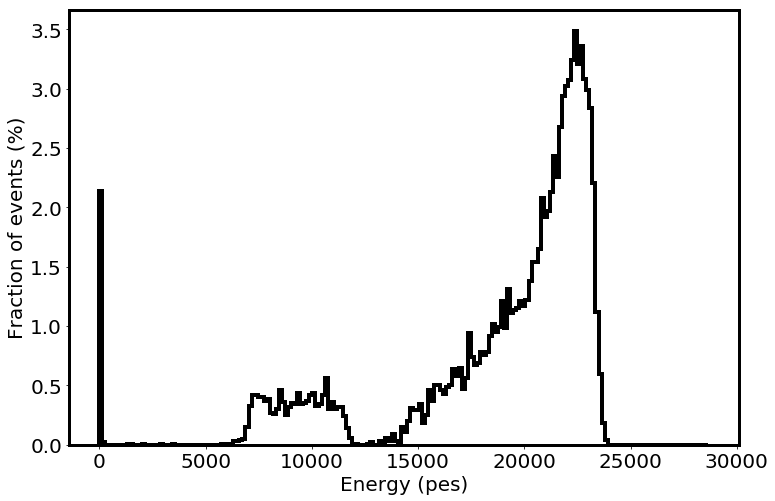

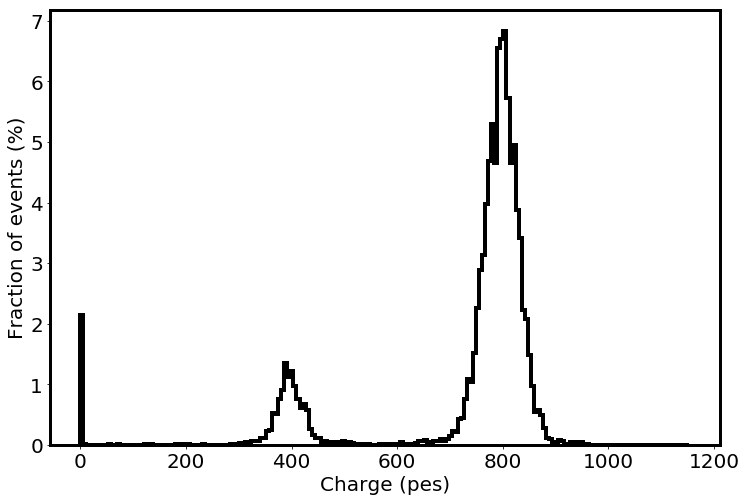

In [8]:
plt.figure()
bins    = (np.linspace(0, energy.max() * 1.2, 201) if max_energy == "auto" else
           np.linspace(0, max_energy        , 201))
weights = np.full(energy.size, 100 / energy.size)
plt.hist(energy, bins, weights=weights, histtype="step")
plt.xlabel("Energy (pes)")
plt.ylabel("Fraction of events (%)")

plt.figure()
bins    = (np.linspace(0, charge.max() * 1.2, 201) if max_charge == "auto" else
           np.linspace(0, max_charge        , 201))
weights = np.full(charge.size, 100 / charge.size)
plt.hist(charge, bins, weights=weights, histtype="step")
plt.xlabel("Charge (pes)")
plt.ylabel("Fraction of events (%)")

# Average waveforms

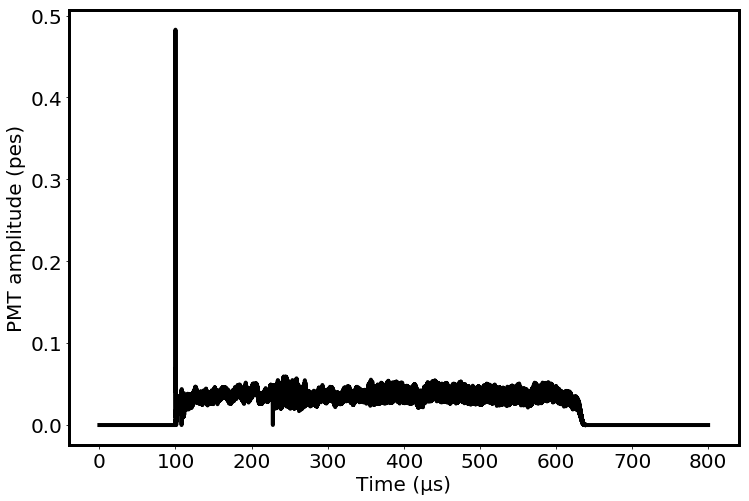

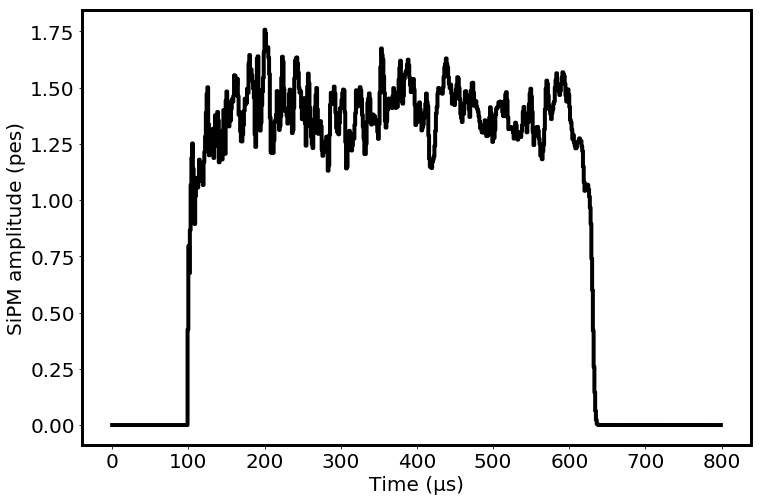

In [9]:
plt.figure()
times = np.arange(avwf_pmt.size) / 1e3
plt.plot(times, avwf_pmt, drawstyle="steps")
plt.xlabel("Time (µs)")
plt.ylabel("PMT amplitude (pes)")

plt.figure()
times = np.arange(avwf_sipm.size)
plt.plot(times, avwf_sipm, drawstyle="steps")
plt.xlabel("Time (µs)")
plt.ylabel("SiPM amplitude (pes)")

# Average position

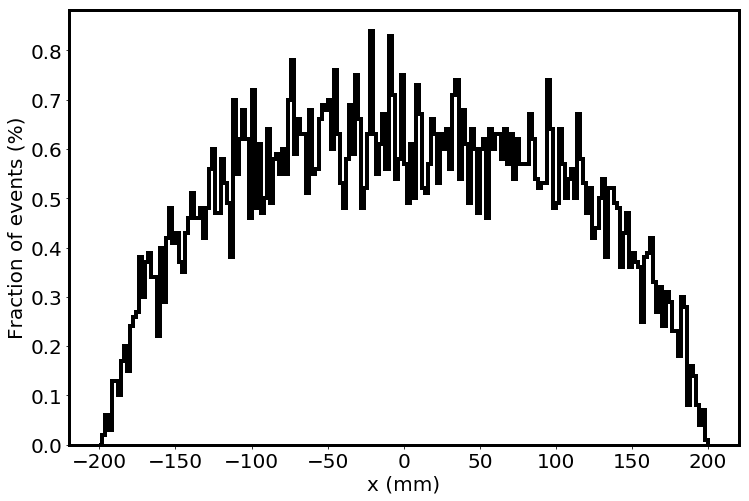

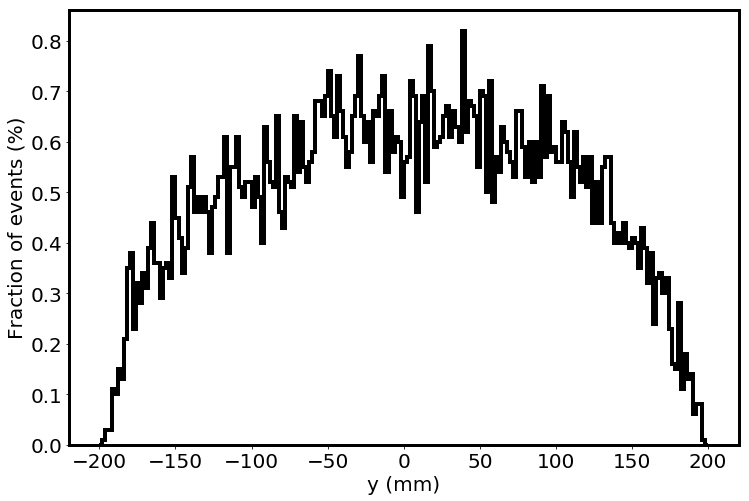

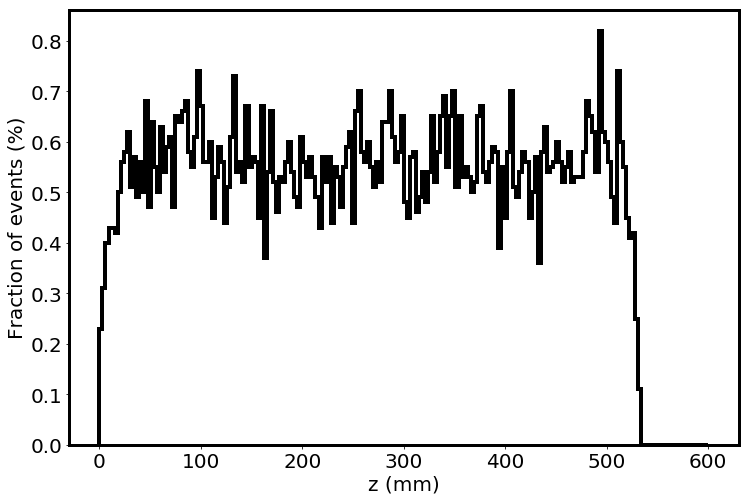

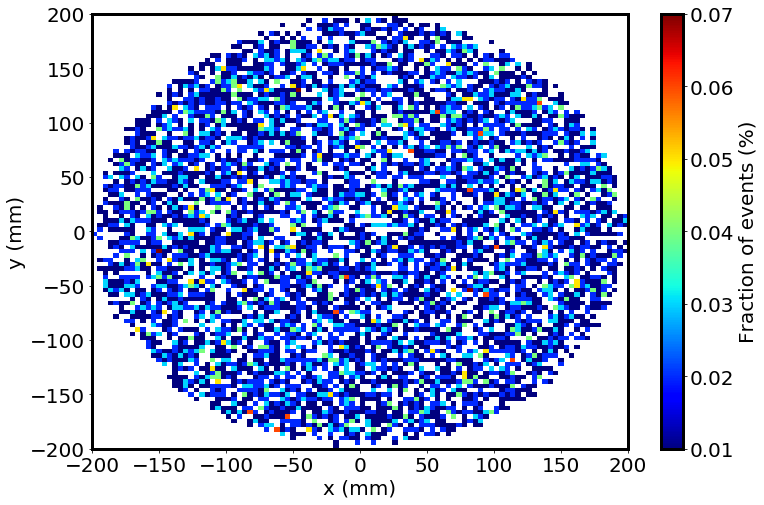

In [10]:
weights = np.full(x_mean.size, 100 / x_mean.size)

plt.figure()
plt.hist(x_mean, np.linspace(-200, 200, 201), weights=weights, histtype="step")
plt.xlabel("x (mm)")
plt.ylabel("Fraction of events (%)")

plt.figure()
plt.hist(y_mean, np.linspace(-200, 200, 201), weights=weights, histtype="step")
plt.xlabel("y (mm)")
plt.ylabel("Fraction of events (%)")

plt.figure()
plt.hist(z_mean, np.linspace(0, 600, 201), weights=weights, histtype="step")
plt.xlabel("z (mm)")
plt.ylabel("Fraction of events (%)")

plt.figure()
plt.hist2d(x_mean, y_mean, (np.linspace(-200, 200, 101),
                            np.linspace(-200, 200, 101)), weights=weights, cmin=1e-8)
plt.colorbar().set_label("Fraction of events (%)")
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")

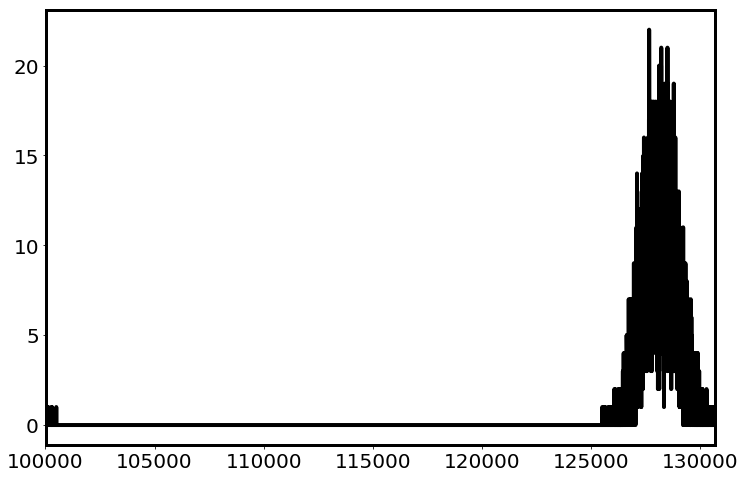

In [17]:
with tb.open_file(input_filenames[0]) as file:
    pmtrd  = file.root. pmtrd
    sipmrd = file.root.sipmrd

    for i in range(pmtrd.shape[0]):
        pmt_wfs  =  pmtrd[i]
        wf = pmt_wfs.sum(axis=0)
        ot = np.argwhere(wf > 0).flatten()
        plt.plot(wf, drawstyle="steps")
        plt.xlim(ot[0], ot[-1])
        break